In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from ramprate.load_dataset import load_epacems, load_epa_crosswalk
import ramprate.build_features as bf

import dask.dataframe as dd
import pandas as pd
from pathlib import Path
from typing import Optional, Sequence
import pudl

In [5]:
import dask

In [6]:
crosswalk = load_epa_crosswalk()

In [70]:
bf.make_subcomponent_ids(crosswalk, cems)

,component_id,plant_id_eia,unitid,unit_id_epa,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,...,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
0,0,469,4,298,263.0,CO,Cherokee,469,4,4,...,39.807275,-104.964548,0.0,0.0,469.0,4,4,4,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
1,1,470,1,299,268.0,CO,Comanche (470),470,1,1,...,38.208100,-104.574700,0.0,0.0,470.0,1,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
2,2,470,2,300,269.0,CO,Comanche (470),470,2,2,...,38.208100,-104.574700,0.0,0.0,470.0,2,2,2,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
3,3,478,1,310,272.0,CO,Zuni,478,1,1,...,39.737348,-105.016991,2010.0,0.0,478.0,1,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
4,3,478,2,311,273.0,CO,Zuni,478,2,1,...,39.737348,-105.016991,2010.0,0.0,478.0,2,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,55,469,5,90850,264.0,CO,Cherokee,469,5,5,...,39.807275,-104.964548,0.0,0.0,469.0,NaN,NaN,5,3_1_Generator (generators) match on plant and ...,NaN
97,55,469,5,90850,265.0,CO,Cherokee,469,5,7,...,39.807275,-104.964548,0.0,0.0,469.0,NaN,NaN,7,3_1_Generator (generators) match on plant and ...,NaN
98,55,469,6,90851,266.0,CO,Cherokee,469,6,7,...,39.807275,-104.964548,0.0,0.0,469.0,NaN,NaN,7,3_1_Generator (generators) match on plant and ...,NaN
99,55,469,6,90851,267.0,CO,Cherokee,469,6,6,...,39.807275,-104.964548,0.0,0.0,469.0,NaN,NaN,6,3_1_Generator (generators) match on plant and ...,NaN


In [120]:
cdf = load_epacems(engine='pandas')

In [121]:
cdf.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)
cdf.sort_index(inplace=True)

In [122]:
cdf = bf._add_subcomponent_ids_and_meta(cdf, crosswalk)['cems']

In [123]:
bf._create_exclusion_flags(cdf)

In [125]:
cdf['exclude_ramp'].mean()

0.22199659142067013

In [ ]:
cems.groupby()

In [220]:
cems = load_epacems(states=None, years=list(range(2015,2020)), engine='dask')

In [221]:
cems = cems.astype({'unit_id_epa': np.int32}).groupby(by="unit_id_epa", group_keys=False)[["plant_id_eia", "unitid", "unit_id_epa"]].first()

In [223]:
%%time
# this took a minute or two and paged to disk
key_map = cems.compute()

In [224]:
key_map

,plant_id_eia,unitid,unit_id_epa
unit_id_epa,,,
1,3,1,1
2,3,2,2
3,3,3,3
4,3,4,4
5,3,5,5
...,...,...,...
91213,61035,01,91213
91311,60589,CT-2,91311
91228,61242,CT1,91228


In [9]:
YEARS = list(range(2015,2020))
STATES = pudl.constants.us_states.keys()  # all states

In [238]:
dfs = [dask.delayed(load_epacems)(states=[state], years=years, engine='pandas') for state in states]

In [239]:
def find_keys(df: pd.DataFrame):
    return df.groupby(by="unit_id_epa")[["plant_id_eia", "unitid"]].first()

In [240]:
delayed_results = [dask.delayed(find_keys)(df) for df in dfs]

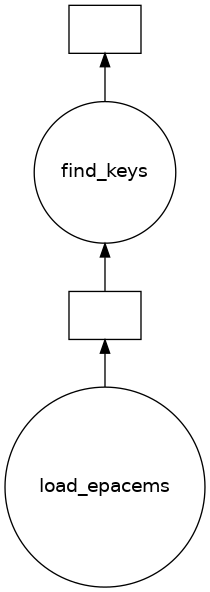

In [241]:
delayed_results[0].visualize()

In [242]:
%%time
out = dask.compute(*delayed_results)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 12.9 µs


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-242-2ae6639f7d9b>", line 2, in <module>
    out = dask.compute(*delayed_results)
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/site-packages/dask/base.py", line 567, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/site-packages/dask/threaded.py", line 79, in get
    results = get_async(
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/site-packages/dask/local.py", line 503, in get_async
    for key, res_info, failed in queue_get(queue).result():
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/site-packages/dask/local.py", line 134, in queue_get
    return q.get()
  File "/home/tpb/miniconda3/envs/pudl-ml/lib/python3.9/queue.py", line 171, in get
    self.not_empty

TypeError: object of type 'NoneType' has no len()

In [1]:
def find_keys2(state):
    df = load_epacems(states=[state], years=YEARS, engine='pandas') 
    return df.groupby(by="unit_id_epa")[["plant_id_eia", "unitid"]].first()

In [7]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:38527 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 18.71 GiB


In [10]:
delayed_results = [dask.delayed(find_keys2)(state) for state in STATES]

In [11]:
delayed_results[0]

Delayed('find_keys2-bf397fe9-3613-4097-b5ad-8eb14599d0ec')

In [12]:
len(delayed_results)

57

In [13]:
%%time
out = dask.compute(*delayed_results)

CPU times: user 3.44 s, sys: 658 ms, total: 4.1 s
Wall time: 49.6 s


In [16]:
sum([len(df) for df in out])

4882

In [17]:
key_map = pd.concat(out, axis=0, sort=True)
key_map.shape

(4882, 2)

In [18]:
key_map.index.unique().shape

(4882,)

want to avoid set_index() if possible. Need to figure out what guarantees I can make about incoming parquet data. Is it sorted by unit_id_epa? do they cross partitions?

In [199]:
cems = cems.astype({'unit_id_epa': np.int32}).set_index('unit_id_epa', drop=False)

In [200]:
cems = cems.repartition(npartitions=2)

In [194]:
cems.divisions

(298, 45580, 90863)

In [204]:
pieces = bf._add_subcomponent_ids_and_meta(cems, crosswalk)

In [205]:
pieces['key_map'].head(3)

,component_id,plant_id_eia,unitid,unit_id_epa,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,...,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER,simple_CAMD_FUEL_TYPE,simple_EIA_FUEL_TYPE
0,0,469,4,298,263.0,CO,Cherokee,469,4,4,...,0.0,0.0,469.0,4,4,4,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...,gas,gas
1,1,470,1,299,268.0,CO,Comanche (470),470,1,1,...,0.0,0.0,470.0,1,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...,coal,coal
2,2,470,2,300,269.0,CO,Comanche (470),470,2,2,...,0.0,0.0,470.0,2,2,2,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...,coal,coal


In [206]:
pieces['meta'].head(3)

,EIA_UNIT_TYPE,capacity_CAMD,capacity_EIA,simple_CAMD_FUEL_TYPE_via_capacity,simple_EIA_FUEL_TYPE_via_capacity,simple_EIA_UNIT_TYPE
component_id,,,,,,
0,(ST),388.0,380.8,gas,gas,steam_turbine
1,(ST),366.0,382.5,coal,coal,steam_turbine
2,(ST),370.0,396.0,coal,coal,steam_turbine


In [207]:
pieces['cems'].head()

,plant_id_eia,unitid,operating_datetime_utc,gross_load_mw,unit_id_epa,component_id,simple_EIA_UNIT_TYPE
unit_id_epa,,,,,,,
298,469,4,2019-01-01 07:00:00+00:00,203.0,298,0,steam_turbine
298,469,4,2019-07-12 20:00:00+00:00,297.0,298,0,steam_turbine
298,469,4,2019-07-12 19:00:00+00:00,297.0,298,0,steam_turbine
298,469,4,2019-07-12 18:00:00+00:00,297.0,298,0,steam_turbine
298,469,4,2019-07-12 17:00:00+00:00,298.0,298,0,steam_turbine


In [208]:
pieces['cems'].npartitions

2

In [209]:
parts = pieces['cems'].to_delayed()

In [210]:
delayed_values = [dask.delayed(bf.process_partition)(part)
                  for part in parts]

In [211]:
out = dask.compute(*delayed_values)

In [214]:
out[0]['component_aggs'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42],
           dtype='int64', name='component_id')

0       299
1       300
2     89734
3       310
4       311
      ...  
66    90560
67    90863
68      298
69    90850
70    90851
Name: unit_id_epa, Length: 71, dtype: int32